# Quaternion convolutional layers reproduction

Firstly I want to check if it possible to recreate the paper. This process will consist of the following steps

- Dataloader
- DataFormatter
- QCNN import 
- QNN import
- Recreate archtitecture 
- Train

# Questions for the following session

- Where does the conversion to quaternions happen
- When we input the output feautures map into the Qlinearlayer we lose all our information right
- Why do de images needed te be padded with a extra dimension

# To do following session

- Train the network

## Modules


In [131]:
import numpy as np
import torch as th
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import core_qnn as qcnn
import torch
import torch.nn as nn
from   torch.nn import Parameter
from   torch.nn import functional as F
import torch.optim
from   torch.autograd import Variable
from   torch import autograd
import os
import pickle
import numpy as np
# Tranform data to PyTorch tensore
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import torchvision

## Dataloader

In [143]:
grayscale = torchvision.transforms.Grayscale(num_output_channels=1)

def convert_data_for_quaternion(batch):
    """
    converts batches of RGB images in 4 channels for QNNs
    """
    assert all(batch[i][0].size(0) == 3 for i in range(len(batch)))
    inputs, labels = [], []
    for i in range(len(batch)):
        inputs.append(torch.cat([batch[i][0], torch.zeros(grayscale(batch[i][0]).size())], 0))
        labels.append(batch[i][1])
    
    return torch.stack(inputs), torch.LongTensor(labels)

transform_train = transforms.Compose(
    [
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
     ])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ]
     )

data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform_train)

Files already downloaded and verified


In [144]:
loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True,collate_fn=convert_data_for_quaternion)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


This is the size of image data torch.Size([4, 32, 32])
This is the size of labels data torch.Size([32])


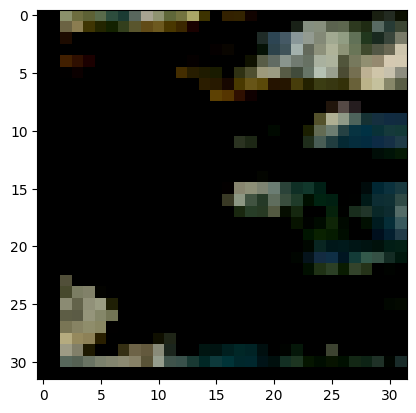

In [145]:
iter_func = iter(loader)

image_data, label_data = next(iter_func)

print("This is the size of image data",image_data[0].shape)

print("This is the size of labels data",label_data.shape)

plt.imshow(image_data[0][:3,:,:].permute((2,1,0)), cmap='Greys_r')

## Creating the model

In [146]:
len(loader)

1563

In [147]:
from   core_qnn.quaternion_layers import QuaternionLinear, QuaternionTransposeConv, QuaternionConv

class NormalModule(nn.Module):
    
    def __init__(self):
        super(NormalModule, self).__init__()
        
        self.layer1 = nn.Linear(3072, 2048)
        self.layer2 = nn.Linear(2048, 516)
        self.layer3 = nn.Linear(516, 10)

    def forward(self, x):
        x = th.flatten(x)
        x = self.layer1.forward(x)
        x = F.relu(x)
        x = self.layer2.forward(x)
        x = F.relu(x)
        x = self.layer3.forward(x)
        x = F.softmax(x)

        return x
    
    def name(self):
        return "SimpleModule"
    



class SimpleModule(nn.Module):
    
    def __init__(self):
        super(SimpleModule, self).__init__()
        
        self.layer1 = QuaternionConv(in_channels=4, out_channels=4, kernel_size = 3, stride = 1, padding = 1)
        self.layer2 = nn.Linear(4096, 516)
        self.layer3 = nn.Linear(516, 10)

    def forward(self, x):
        x = self.layer1.forward(x)
        x = F.relu(x)
        x = th.flatten(x)
        x = self.layer2.forward(x)
        x = F.relu(x)
        x = self.layer3.forward(x)
        x = F.softmax(x)

        return x
    
    def name(self):
        return "SimpleModule"
    
class TheModule(nn.Module):
    
    def __init__(self):
        super(TheModule, self).__init__()
        
        self.layer1 = QuaternionConv(in_channels=4, out_channels=32, kernel_size = 3, stride = 1, padding = 1)
        self.layer2 = QuaternionConv(in_channels=32, out_channels=32, kernel_size = 3, stride = 1, padding = 1)
        self.layer3 = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.layer4 = nn.Dropout(0.25)

        self.layer5 = QuaternionConv(in_channels=32, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.layer6 = QuaternionConv(in_channels=64, out_channels=64, kernel_size = 3, stride = 1, padding = 1)

        # self.layer7 = QuaternionLinear(4096, 512)
        self.layer7 = nn.Linear(4096, 512)
        
        # self.layer8 = QuaternionLinear(512, 10)
        self.layer8 = nn.Linear(512, 10)

        self.layer9 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1.forward(x)
        x = F.relu(x)
        x = self.layer2.forward(x)
        x = F.relu(x)
        x = self.layer3(x)
        # x = self.layer4(x)
        
        x = self.layer5.forward(x)
        x = F.relu(x)
        x = self.layer6.forward(x)
        x = F.relu(x)
        x = self.layer3(x)
        # x = self.layer4(x) 
        
        flat = nn.Flatten()
        x = flat(x)
        
        x = self.layer7.forward(x)
        x = F.relu(x)
        x = self.layer8.forward(x)
        # x = self.layer9(x)
        x = th.sigmoid(x)

        return x
    
    def name(self):
        return "SimpleModule"
    
class CNNModule(nn.Module):
    
    def __init__(self):
        super(CNNModule, self).__init__()
        
        self.layer1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size = 3, stride = 1, padding = 1)
        self.layer2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size = 3, stride = 1, padding = 1)
        self.layer3 = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.layer4 = nn.Dropout(0.25)

        self.layer5 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size = 3, stride = 1, padding = 1)
        self.layer6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size = 3, stride = 1, padding = 1)

        # self.layer7 = QuaternionLinear(4096, 512)
        self.layer7 = nn.Linear(1024, 512)
        
        # self.layer8 = QuaternionLinear(512, 10)
        self.layer8 = nn.Linear(512, 10)

        self.layer9 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1.forward(x)
        x = F.relu(x)
        x = self.layer2.forward(x)
        x = F.relu(x)
        x = self.layer3(x)
        # x = self.layer4(x)
        
        x = self.layer5.forward(x)
        x = F.relu(x)
        x = self.layer6.forward(x)
        x = F.relu(x)
        x = self.layer3(x)
        # x = self.layer4(x) 
        flat = nn.Flatten()
        x = flat(x)
        
        x = self.layer7.forward(x)
        x = F.relu(x)
        x = self.layer8.forward(x)
        # x = self.layer9(x)
        x = th.sigmoid(x)

        return x
    
    def name(self):
        return "SimpleModule"



## Choose your network

In [148]:
# Choose your model
if False: 
    model = SimpleModule().cuda(); 
    loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True,collate_fn=convert_data_for_quaternion)


if False: 
    model = TheModule().cuda(); 
    loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True,collate_fn=convert_data_for_quaternion)

if True: 
    model = CNNModule().cuda(); 
    loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)

if False:
    model = NormalModule().cuda(); 
    loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True,collate_fn=convert_data_for_quaternion)


criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr = 0.0001,weight_decay=1e-6)

## Training the network 


In [149]:
num_epochs = 80
losses = []
running_loss = 0
for epoch in range(num_epochs):

    running_loss = 0
    for inputs, labels in loader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        running_loss += loss.cpu().item()
        # print statistics
            # Print progress
    if (epoch+1) % 1 == 0:
        losses.append(running_loss/1563)
        print ('Epoch [{}/{}], Loss: {:.4f}'
            .format(epoch+1, num_epochs, loss.cpu().item()))
        print(f"Running loss {running_loss/1563}")

print('Finished Training')

Epoch [1/80], Loss: 2.0195
Running loss 2.0867677730241803
Epoch [2/80], Loss: 2.0035
Running loss 2.000150076487243
Epoch [3/80], Loss: 2.0528
Running loss 1.9749164302152316
Epoch [4/80], Loss: 1.8401
Running loss 1.9579135607391767
Epoch [5/80], Loss: 2.0482
Running loss 1.944014552611231
Epoch [6/80], Loss: 1.9591
Running loss 1.9293911155034393
Epoch [7/80], Loss: 1.9111
Running loss 1.9168982004707469
Epoch [8/80], Loss: 2.1567
Running loss 1.9067949566105886
Epoch [9/80], Loss: 1.9547
Running loss 1.8969222936428898
Epoch [10/80], Loss: 1.8596
Running loss 1.8872254342508104
Epoch [11/80], Loss: 1.8216
Running loss 1.879634945269052
Epoch [12/80], Loss: 1.8685
Running loss 1.8724615938451454
Epoch [13/80], Loss: 1.7968
Running loss 1.8649035783738412
Epoch [14/80], Loss: 1.8964
Running loss 1.859607037335577
Epoch [15/80], Loss: 1.8552
Running loss 1.8536971672482774
Epoch [16/80], Loss: 1.9589
Running loss 1.8479932006627264
Epoch [17/80], Loss: 1.8040
Running loss 1.8436522479

## Plotting and saving the data



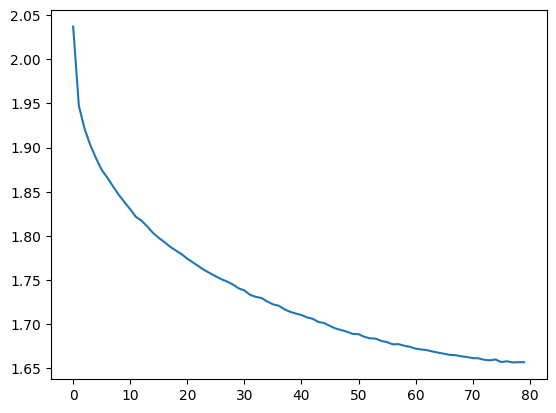

In [139]:
import datetime
import pandas as pd
x = datetime.datetime.now()

appendix = "CNN_with_normalization"
string = str(x.day) + "_" + str(x.hour) + "_" + str(x.minute) + "_" + str(x.second) + "_" + str(appendix)

# Plotter
plt.plot(range(len(losses)), losses)
plt.savefig( f"./modelsParameters/{string}.png")
plt.show()

# Torch
torch.save(model.state_dict(), f"./modelsParameters/{string}")

# Pandas
df = pd.DataFrame(losses, columns=["Losses"])
df.to_csv( f"./modelsParameters/{string}.csv", index=False)

In [140]:
data_test = datasets.CIFAR10(root='data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(data_test, batch_size=10000, shuffle=False, \
    collate_fn=convert_data_for_quaternion)

# Model is normal cnn
# data_test = datasets.CIFAR10(root='data', train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(data_test, batch_size=10000, shuffle=False)

Files already downloaded and verified


## Retrieve

In [35]:
model = TheModule().cuda()
model.load_state_dict(torch.load("./hoi"))
model.eval()

TheModule(
  (layer1): QuaternionConv(in_channels=1, out_channels=8, bias=True, kernel_size=(3, 3), stride=1, padding=1, init_criterion=glorot, weight_init=quaternion, seed=636, rotation=False, q_format=True, operation=convolution2d)
  (layer2): QuaternionConv(in_channels=8, out_channels=8, bias=True, kernel_size=(3, 3), stride=1, padding=1, init_criterion=glorot, weight_init=quaternion, seed=282, rotation=False, q_format=True, operation=convolution2d)
  (layer3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer4): Dropout(p=0.25, inplace=False)
  (layer5): QuaternionConv(in_channels=8, out_channels=16, bias=True, kernel_size=(3, 3), stride=1, padding=1, init_criterion=glorot, weight_init=quaternion, seed=1001, rotation=False, q_format=True, operation=convolution2d)
  (layer6): QuaternionConv(in_channels=16, out_channels=16, bias=True, kernel_size=(3, 3), stride=1, padding=1, init_criterion=glorot, weight_init=quaternion, seed=802, rotation=False, q_f

In [141]:
torch.cuda.empty_cache()

In [142]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for inputs, labels in testloader:
        images, labels = inputs.to('cuda'), labels.to('cuda')
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        torch.cuda.empty_cache()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.4f}%')

Accuracy of the network on the 10000 test images: 74.0000%
